# Imports

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
# Maybe use https://gitlab.com/mike01/pypacker or https://stackoverflow.com/questions/30826123/python-scapy-vs-dpkt
import scapy
import pickle
import subprocess
from subprocess import PIPE
from pathlib import Path
from datetime import datetime, timedelta
from scapy.all import *
import networkx as nx
import matplotlib.dates as mdates
import statistics
import re
import sharedVariables
from sharedVariables import *

In [315]:
# Datasets
dataset_sources = {
    'advanced': 'data/data-advanced-mongo-with-latency-9/20210930-06-experiment-advanced-mongo-with-latency-9',
    'baseline': 'data/data-baseline-with-latency-9/20210930-03-experiment-baseline-with-latency-9',
    'syncmesh': 'data/data-syncmesh-with-latency-9/20210930-04-experiment-syncmesh-with-latency-9'
}
dataset_sources = {
    'advanced': 'data/data-advanced-mongo-with-latency-6/20210929-22-experiment-advanced-mongo-with-latency-6',
    'baseline': 'data/data-baseline-with-latency-6/20210929-11-experiment-baseline-with-latency-6',
    'syncmesh': 'data/data-syncmesh-with-latency-6/20210929-11-experiment-syncmesh-with-latency-6'
}
dataset_sources = {
    'advanced': 'data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3',
    'baseline': 'data/data-baseline-with-latency-3/20210929-21-experiment-baseline-with-latency-3',
    'syncmesh': 'data/data-syncmesh-with-latency-3/20210929-21-experiment-syncmesh-with-latency-3'
}
try: 
    print(ci)
except Exception:  
    ci = False

if ci == "true": 
    dataset_sources = {}
    print("Running CI Data detection")
    for folder in os.listdir("data"):
        if folder.startswith("data"):
            dashes = [m.start() for m in re.finditer('-', folder)]
            dataset_sources[folder[5:dashes[1]]] = "data/" + folder + "/" + os.listdir("data/" + folder)[0]
dataset_sources

False


{'advanced': 'data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3',
 'baseline': 'data/data-baseline-with-latency-3/20210929-21-experiment-baseline-with-latency-3',
 'syncmesh': 'data/data-syncmesh-with-latency-3/20210929-21-experiment-syncmesh-with-latency-3'}

In [316]:
# Utility Functions
def to_human_readable(size, unit=True):
    power = 1000
    n = 0
    mem = {0 : 'B', 1: 'KB', 2: 'MB', 3: 'GB', 4: 'TB'}
    while size > power:
        size /=  power
        n += 1
    if unit:
        return "{0:.2f} {1}".format(size, mem[n])
    else:
        return "{0:.2f}".format(size)

def to_MB(size, unit=True):
    size /= 1000*1000
    return "{0:.2f}".format(size)

In [317]:
ip_seperator

'92.60.39.199'

In [318]:
def filterDataForSeperator(df): 
    df = df[df["ip.src"].isin([ip_seperator, ip_client])]
    df = df[df["ip.dst"].isin([ip_seperator, ip_client])]
    df = df[(df["tcp.dstport"] == 443)] #  | (df["tcp.srcport"] == 443)
    return df

def filterDataForLocalTraffic(df): 
    df = df[df["ip.src"].str.contains(r'^10\.')]
    df = df[df["ip.dst"].str.contains(r'^10\.')]
    df = df[(df["tcp.dstport"] != 22) & (df["tcp.srcport"] != 22)]
    return df

def loadDataSet(folder):
    df_base = None
    for filename in os.listdir(folder):
        if filename.endswith(".csv") and filename.startswith("10"):
            csvfile = os.path.join(Path.cwd(), folder, filename)
            print(csvfile)
            EPOCH = datetime(1900, 1, 1)
            currentdf = pd.read_csv(csvfile)
            # print(len(currentdf))

            currentdf["frame.time_epoch"] = currentdf["frame.time_epoch"].apply(lambda x: datetime.utcfromtimestamp(float(x)))

            currentdf.set_index('frame.time_epoch', inplace=True)

            currentdf.dropna(inplace=True,subset=['ip.src', 'ip.dst'])
            # currentdf.to_csv(filename + ".csv")

            if (df_base is None):
                df_base = currentdf
            else:
                df_base = df_base.append(currentdf)

        else:
            continue

    seperatordf = filterDataForSeperator(df_base)
    timings = seperatordf.index.values
    # df_base.sort_index().to_csv("test.csv")
    # print(df_base)
    df_base = filterDataForLocalTraffic(df_base)
    node_list = list(dict.fromkeys(df_base["ip.src"].unique().tolist() + df_base["ip.dst"].unique().tolist()))
    node_list = [node for node in node_list if node not in ["10.0.0.2", "10.0.0.3", "10.0.0.4", "10.0.0.255"]]
    print(node_list)
    return (df_base.sort_index(), timings, len(node_list))

datasets = {}
for source in dataset_sources:
    datasets[source] = loadDataSet(dataset_sources[source])

    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
datasets["advanced"][1]

c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3\10.0.0.2.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3\10.0.0.3.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3\10.1.0.11.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3\10.2.0.12.pcap.csv
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3\10.3.0.13.pcap.csv
['10.2.0.12', '10.1.0.11', '10.3.0.13']
c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-baseline-with-latency-3/20210929-21-experiment-baseline-with-latency-3\10.0.0.2.pcap.csv
c:\Develop\GitHub\DSP

array(['2021-09-29T20:31:20.095964000', '2021-09-29T20:34:42.932285000',
       '2021-09-29T20:38:23.603221000', '2021-09-29T20:42:19.368023000',
       '2021-09-29T20:46:45.700052000', '2021-09-29T20:50:03.752167000',
       '2021-09-29T20:53:22.123790000', '2021-09-29T20:56:40.299674000',
       '2021-09-29T20:59:58.907611000'], dtype='datetime64[ns]')

In [319]:
df = datasets["syncmesh"][0]
# df[(df['ip.src']=='10.1.0.11') & (df['ip.dst']=='10.2.0.12')]
# df[(df['ip.src']=='10.1.0.11')]
df

,tcp.analysis.initial_rtt,ip.id,ip.src,ip.dst,ip.len,tcp.srcport,tcp.dstport
frame.time_epoch,,,,,,,
2021-09-29 20:32:29.176927,NaN,0x000000ce,10.0.0.2,10.1.0.11,60.0,51548.0,8080.0
2021-09-29 20:32:29.191751,NaN,0x000000ce,10.0.0.2,10.1.0.11,60.0,51548.0,8080.0
2021-09-29 20:32:29.191826,NaN,0x00000000,10.1.0.11,10.0.0.2,60.0,8080.0,51548.0
2021-09-29 20:32:29.206461,NaN,0x00000000,10.1.0.11,10.0.0.2,60.0,8080.0,51548.0
2021-09-29 20:32:29.206517,0.029590,0x000000cf,10.0.0.2,10.1.0.11,52.0,51548.0,8080.0
...,...,...,...,...,...,...,...
2021-09-29 20:58:11.337271,0.117180,0x00004ac1,10.1.0.11,10.3.0.13,52.0,57960.0,8080.0
2021-09-29 20:58:11.350351,0.185839,0x000095cb,10.2.0.12,10.1.0.11,52.0,8080.0,45886.0
2021-09-29 20:58:11.395366,0.116226,0x00004ac1,10.1.0.11,10.3.0.13,52.0,57960.0,8080.0


In [320]:
def calcSubset(df):
    nodes = list(dict.fromkeys(df["ip.src"].unique().tolist() + df["ip.dst"].unique().tolist()))
    # print(nodes)
    betweenNodesDataset = {}
    nodeCombinations = list(itertools.combinations(nodes, r=2))
    for combination in nodeCombinations: 
        # print(combination)
        # print(df[df['ip.src']==combination[0] & df['ip.dst']==combination[1]])
        # Use both src_ip and dest_ip as they are not request related
        key = "between " + combination[0] + " and " + combination[1]
        betweenNodesDataset[key] = df[((df['ip.src']==str(combination[0])) & (df['ip.dst']==str(combination[1]))) | ((df['ip.src']==str(combination[1])) & (df['ip.dst']==str(combination[0])))]

    return betweenNodesDataset

node_datasets = {}
for key in datasets:
    node_datasets[key] = calcSubset(datasets[key][0])

# setname = "syncmesh"
# for key in node_datasets[setname]:
#     print(key, ":", len(node_datasets[setname][key]))
    # print(node_datasets[setname][key])
    

In [321]:
# Experiments
def splitExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = calcSubset(df.loc[str(timings[index]):str(timings[index + 1])])
    return return_data

node_experiment_datasets = {}
for key in datasets:
    print(key)
    print(datasets[key][1])
    node_experiment_datasets[key] = splitExperiments(datasets[key][0], datasets[key][1])

setname = "syncmesh"
for key in node_experiment_datasets[setname]:
    print(key, ":", len(node_experiment_datasets[setname][key]))


advanced
['2021-09-29T20:31:20.095964000' '2021-09-29T20:34:42.932285000'
 '2021-09-29T20:38:23.603221000' '2021-09-29T20:42:19.368023000'
 '2021-09-29T20:46:45.700052000' '2021-09-29T20:50:03.752167000'
 '2021-09-29T20:53:22.123790000' '2021-09-29T20:56:40.299674000'
 '2021-09-29T20:59:58.907611000']
baseline
['2021-09-29T20:31:29.029101000' '2021-09-29T20:34:53.392254000'
 '2021-09-29T20:38:39.508039000' '2021-09-29T20:42:47.036098000'
 '2021-09-29T20:47:44.120228000' '2021-09-29T20:51:07.768155000'
 '2021-09-29T20:54:39.508323000' '2021-09-29T20:58:20.216742000'
 '2021-09-29T21:02:20.956043000']
syncmesh
['2021-09-29T20:31:28.381675000' '2021-09-29T20:34:44.129480000'
 '2021-09-29T20:38:20.413526000' '2021-09-29T20:42:03.917572000'
 '2021-09-29T20:46:12.605579000' '2021-09-29T20:49:26.629449000'
 '2021-09-29T20:52:42.317704000' '2021-09-29T20:55:56.781791000'
 '2021-09-29T20:59:11.897785000']
collect1 : 6
collect7 : 6
collect14 : 6
collect30 : 6
aggregate1 : 6
aggregate7 : 6
aggrega

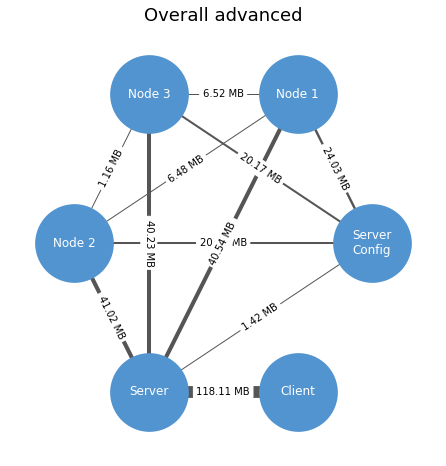

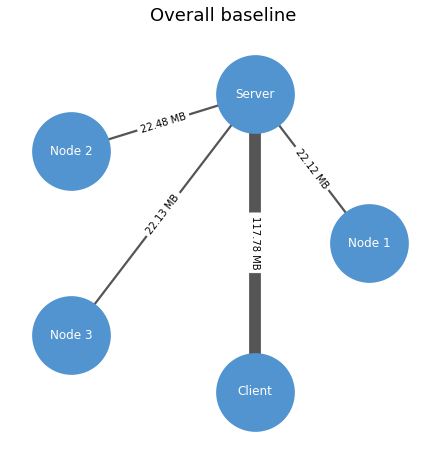

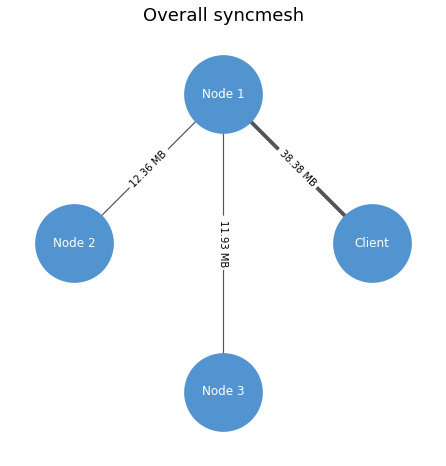

In [338]:
def get_node_name(ip):
    if(ip == "10.0.0.2"):
        return "Client"
    elif(ip == "10.0.0.3"):
        return "Server"
    elif(ip == "10.0.0.4"):
        return "Server\nConfig"
    elif(ip == "10.0.0.255"):
        return "ORCHESTRATOR"
    elif(ip.startswith("10.")):
        return "Node " + ip.split(".")[1]
    return ip

for index, subset_key in enumerate(node_datasets):
    G = nx.Graph()
    # print(subset_key)
    for node_dataset_key in node_datasets[subset_key]: 
        subset = node_datasets[subset_key][node_dataset_key]
        if len(subset["ip.dst"]) > 0:

            # if subset_key == "advanced":
                # print(node_dataset_key) 
                #print(subset["ip.src"].iloc[0], subset["ip.dst"].iloc[0]) 
                #print(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]))
            G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='#555555', weight=np.clip(subset["ip.len"].sum()/10000000 , 1, 1000), label=to_human_readable(subset["ip.len"].sum()))
            #  + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms"

    pos = nx.circular_layout(G)
    
    size=datasets[subset_key][2]/3 * 6
    plt.figure(index+1,figsize=(size,size))
    edges = G.edges()
    colors = [G[u][v]['color'] for u,v in edges]
    weights = [G[u][v]['weight'] for u,v in edges]
    edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
    nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="#5294CF", font_color="w", node_shape="o", alpha=1, linewidths=40)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

    plt.axis('off')
    axis = plt.gca()
    axis.set_title("Overall " + subset_key)
    axis.set_xlim([1.2*x for x in axis.get_xlim()])
    axis.set_ylim([1.2*y for y in axis.get_ylim()])
    plt.savefig("out/network_"+subset_key+".png")
    

plt.show()

In [323]:
# node_experiment_datasets["syncmesh"]["aggregate30"]['between 10.2.0.12 and 10.1.0.11'].to_csv("test.csv")
# node_experiment_datasets["baseline"]["aggregate30"]['between 10.1.0.3 and 10.1.0.2'].to_csv("test2.csv")

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/1851211818.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(int(str(index)+str(e_index)),figsize=(size,size))


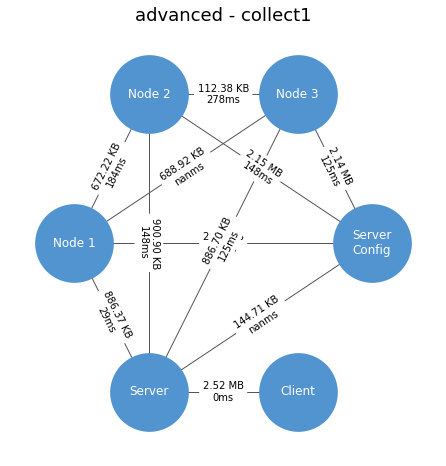

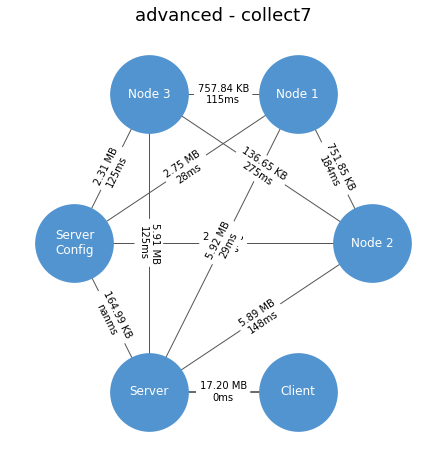

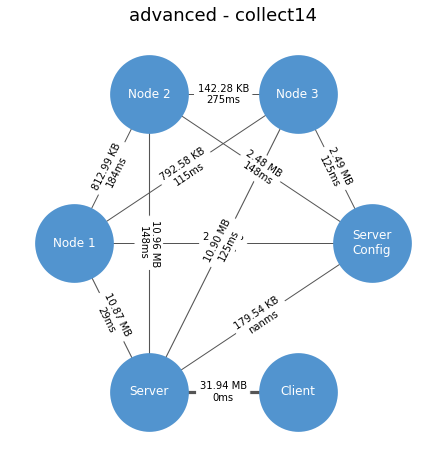

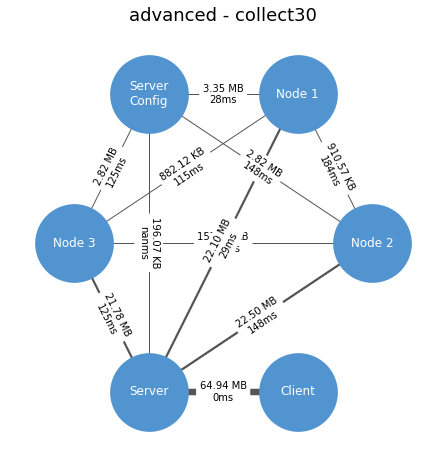

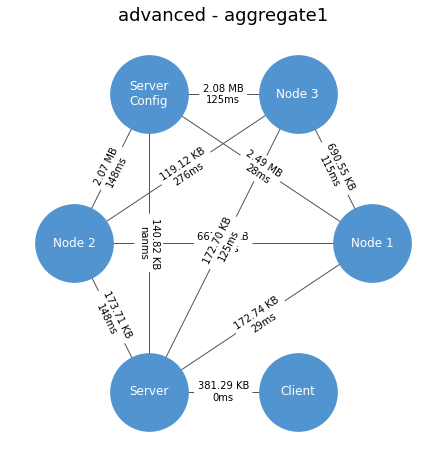

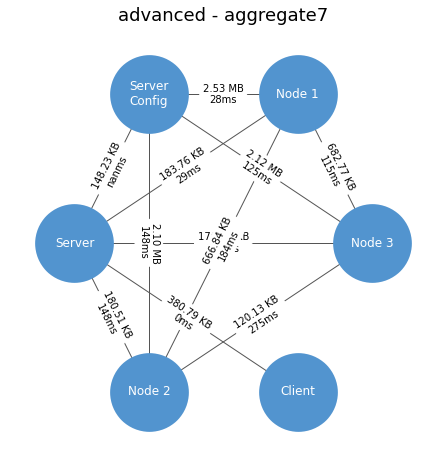

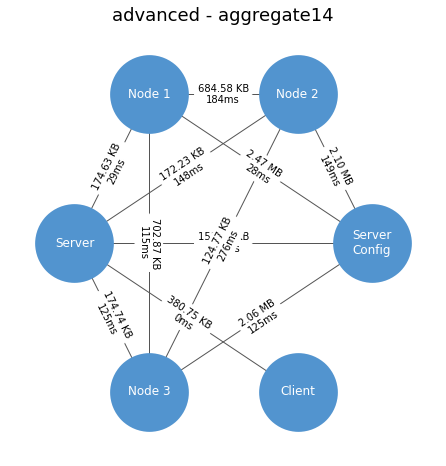

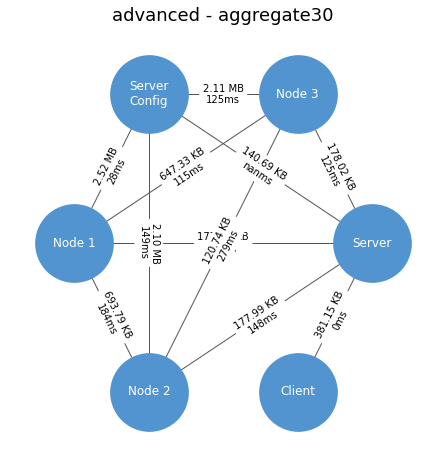

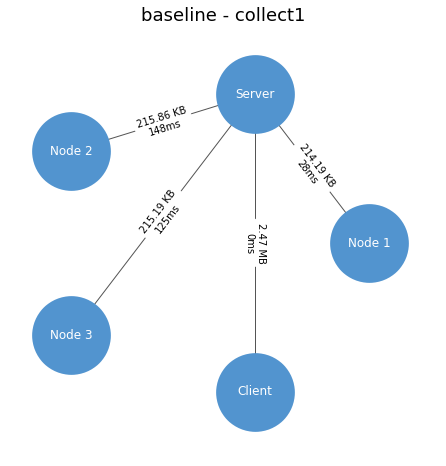

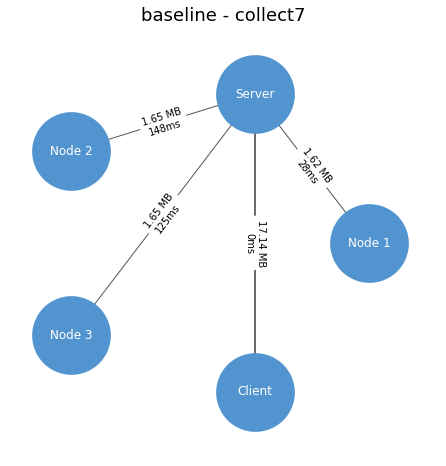

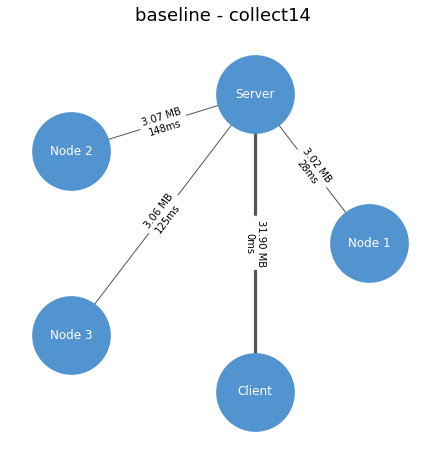

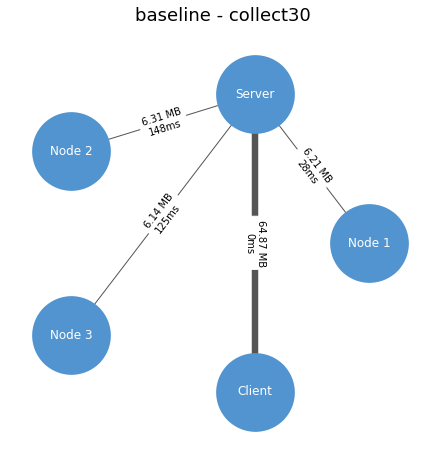

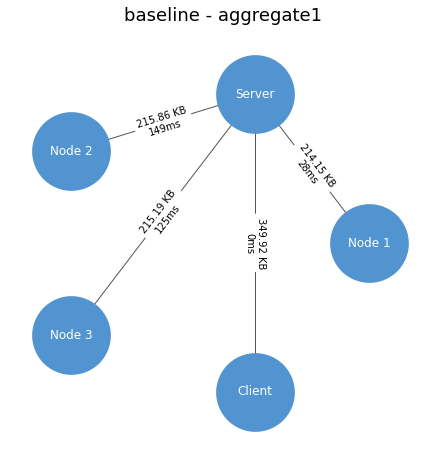

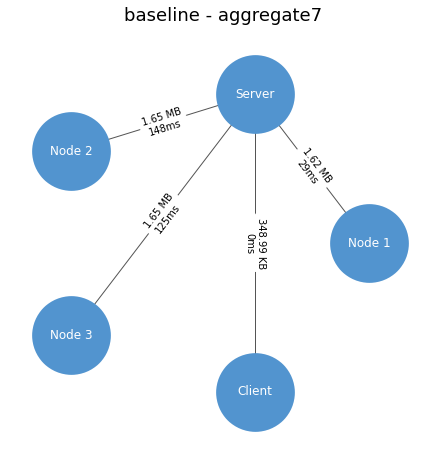

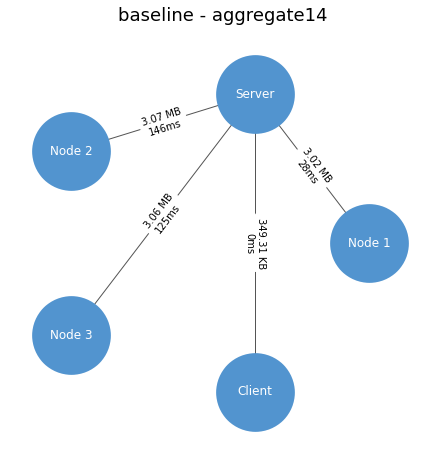

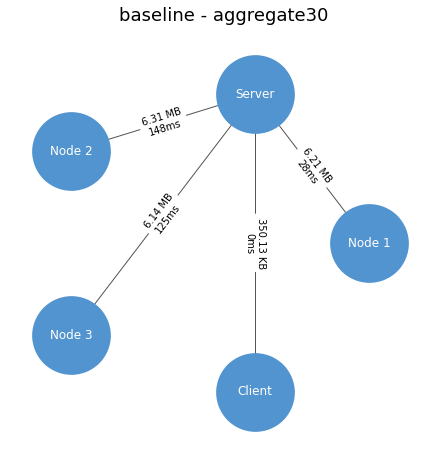

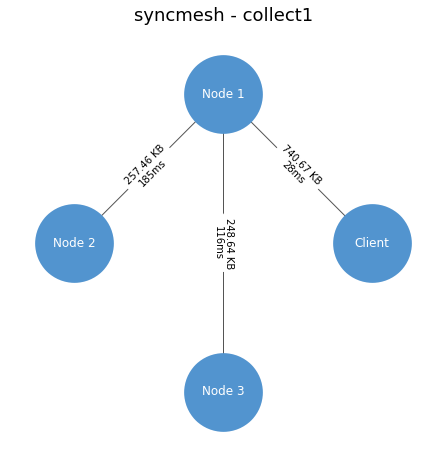

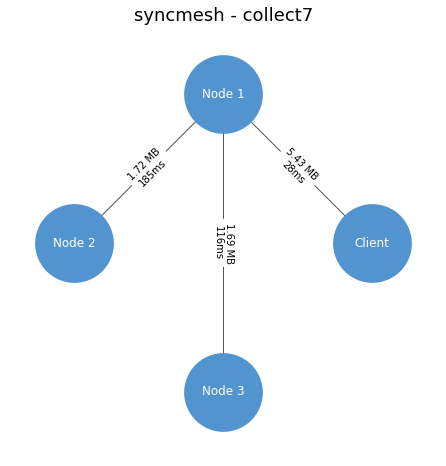

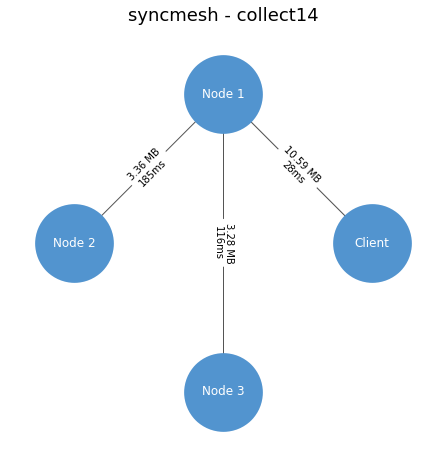

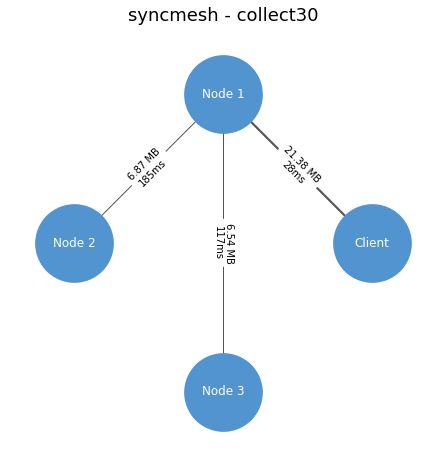

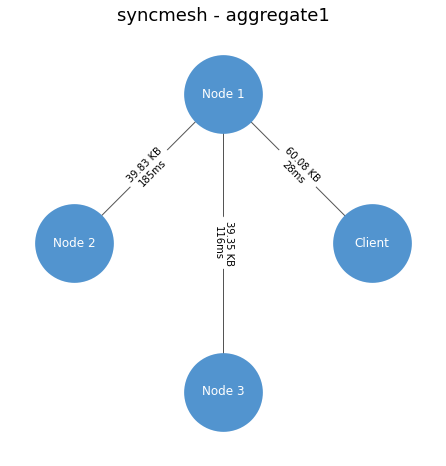

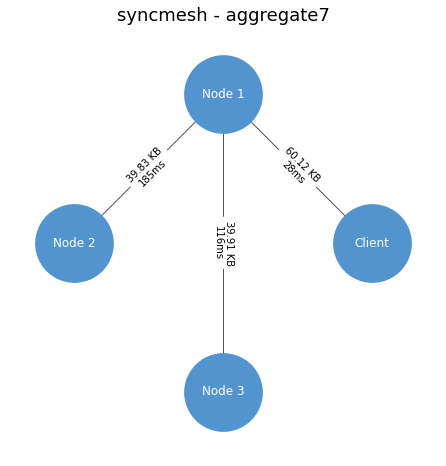

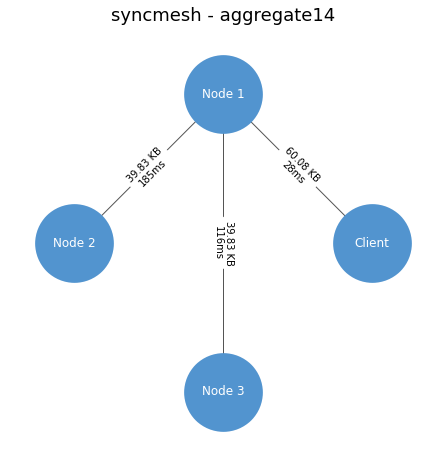

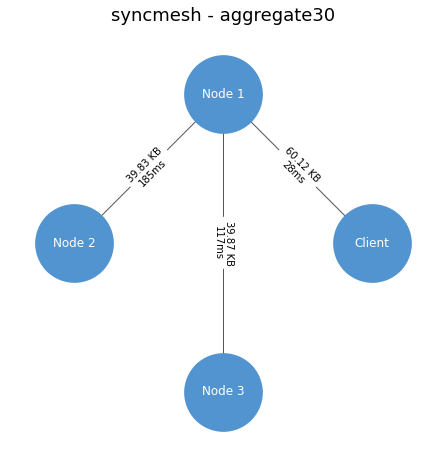

In [342]:
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        # print(experiment_key)
        G = nx.Graph()
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            if len(subset["ip.dst"]) > 0:
                # print(node_dataset_key) 
                G.add_edge(get_node_name(subset["ip.src"].iloc[0]), get_node_name(subset["ip.dst"].iloc[0]), color='#555555', weight=np.clip(subset["ip.len"].sum()/10000000 , 1, 1000), label=to_human_readable(subset["ip.len"].sum()) + "\n" + "{:.0f}".format(subset["tcp.analysis.initial_rtt"].mean(skipna=True)* 1000) + "ms")
                # print(subset["tcp.analysis.initial_rtt"].mean()* 1000)

        pos = nx.circular_layout(G)
        size=datasets[subset_key][2]/3 * 6
        plt.figure(int(str(index)+str(e_index)),figsize=(size,size))
        edges = G.edges()
        colors = [G[u][v]['color'] for u,v in edges]
        weights = [G[u][v]['weight'] for u,v in edges]
        edgelabels = dict([((u, v), G[u][v]['label']) for u,v in edges])
        nx.draw(G, pos, edge_color=colors, width=weights, with_labels = True, node_size=1500, node_color="#5294CF", font_color="w", node_shape="o", alpha=1, linewidths=40)
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edgelabels)

        plt.axis('off')
        axis = plt.gca()
        axis.set_title(subset_key + " - " + experiment_key)
        axis.set_xlim([1.2*x for x in axis.get_xlim()])
        axis.set_ylim([1.2*y for y in axis.get_ylim()])
        plt.savefig("out/network_"+subset_key+"-"+experiment_key+".png")

# node_experiment_datasets
# plt.show()

In [325]:
from string import digits

s = 'abc123def456ghi789zero0'
remove_digits = str.maketrans('', '', digits)


subset_col = []
experiment_group_col = []
experiment_col = []
traffic_col = []
rtt_col = []
print("Aggregated Traffic")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        subset_col.append(subset_key)   
        experiment_group_col.append(experiment_key.translate(remove_digits))
        experiment_col.append(experiment_key)
        sum_bytes = 0
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            sum_bytes = sum_bytes + subset["ip.len"].sum()

        traffic_col.append(sum_bytes)
        print(subset_key + " - " + experiment_key + ": " + to_human_readable(sum_bytes))

print("Median RTT")
for index, subset_key in enumerate(node_experiment_datasets):
    # print(subset_key)
    for e_index, experiment_key in enumerate(node_experiment_datasets[subset_key]):
        rtt = np.array([])
        for node_dataset_key in node_experiment_datasets[subset_key][experiment_key]: 
            subset = node_experiment_datasets[subset_key][experiment_key][node_dataset_key]
            rtt = np.append(rtt, subset["tcp.analysis.initial_rtt"].mean())

        # print(rtt)
        rtt_col.append(np.nanmean(rtt) * 1000)
        print(subset_key + " - " + experiment_key + ": " + str(np.nanmean(rtt) * 1000) + " msec " + str(statistics.median(rtt)))

Aggregated Traffic
advanced - collect1: 13.67 MB
advanced - collect7: 44.09 MB
advanced - collect14: 74.53 MB
advanced - collect30: 142.46 MB
advanced - aggregate1: 9.16 MB
advanced - aggregate7: 9.29 MB
advanced - aggregate14: 9.21 MB
advanced - aggregate30: 9.26 MB
baseline - collect1: 3.12 MB
baseline - collect7: 22.05 MB
baseline - collect14: 41.05 MB
baseline - collect30: 83.52 MB
baseline - aggregate1: 995.11 KB
baseline - aggregate7: 5.26 MB
baseline - aggregate14: 9.50 MB
baseline - aggregate30: 19.00 MB
syncmesh - collect1: 1.25 MB
syncmesh - collect7: 8.84 MB
syncmesh - collect14: 17.24 MB
syncmesh - collect30: 34.78 MB
syncmesh - aggregate1: 139.26 KB
syncmesh - aggregate7: 139.85 KB
syncmesh - aggregate14: 139.74 KB
syncmesh - aggregate30: 139.82 KB
Median RTT
advanced - collect1: 118.46297952337443 msec 0.12528850000000005
advanced - collect7: 117.71864061439204 msec 0.1478625361764706
advanced - collect14: 117.81692341626874 msec 0.11462549999999999
advanced - collect30: 

In [326]:
analyze_table = pd.DataFrame(dict(experiment=subset_col,
scenario=experiment_group_col,
                  scenario_nodes=experiment_col,
                  traffic=traffic_col,
                  rtt=rtt_col))



sum_table = analyze_table.groupby(["experiment", "scenario"]).agg(
    traffic=("traffic", "sum"), rtt_mean=("rtt", "mean"))


def our_sort(index):
    print(index)
    # if index.name == "subset":
    print(index)
    return index 



# sum_table["rtt_mean"] = sum_table["rtt_mean"].apply(lambda x: "{:.0f} ({:+.2%})".format(x,(1-sum_table["rtt_mean"][2] / x )))
# sum_table["traffic"] = sum_table["traffic"].apply(lambda x: to_human_readable(x, False) + " ({:+.2%})".format(1-(sum_table["traffic"][2] / x )))
sum_table = sum_table.unstack(level=-1).reindex(['baseline', 'advanced', 'syncmesh'])

extra_table = sum_table.copy()
extra_table.columns = ['.'.join(col).strip() for col in sum_table.columns.values]

for scenario in ["aggregate", "collect"]:
    extra_table["rtt_mean." + scenario] = extra_table["rtt_mean." + scenario].apply(lambda x: "{:.0f} ({:+.1%})".format(x,(1-extra_table["rtt_mean." + scenario][0] / x )))
    extra_table["traffic." + scenario] = extra_table["traffic." + scenario].apply(lambda x: to_MB(x, False) + " ({:+.1%})".format(1-(extra_table["traffic." + scenario][0] / x )))
extra_extra_table = extra_table.columns.str.split('.', expand=True)

extra_table.columns = extra_extra_table

extra_table.rename(columns={"traffic": "Traffic (in MB)", "rtt_mean": "RTT (in ms)"}, inplace=True)
extra_table.to_latex("out/sum_table.tex")
extra_table.to_csv("out/sum_table.csv")
extra_table


Traffic (in MB)                    RTT (in ms)              
                  aggregate          collect     aggregate       collect
experiment                                                              
baseline      34.76 (+0.0%)   149.75 (+0.0%)    75 (+0.0%)    75 (+0.0%)
advanced      36.91 (+5.8%)  274.75 (+45.5%)  118 (+36.2%)  118 (+36.1%)
syncmesh    0.56 (-6121.8%)  62.11 (-141.1%)  110 (+31.5%)  110 (+31.4%)

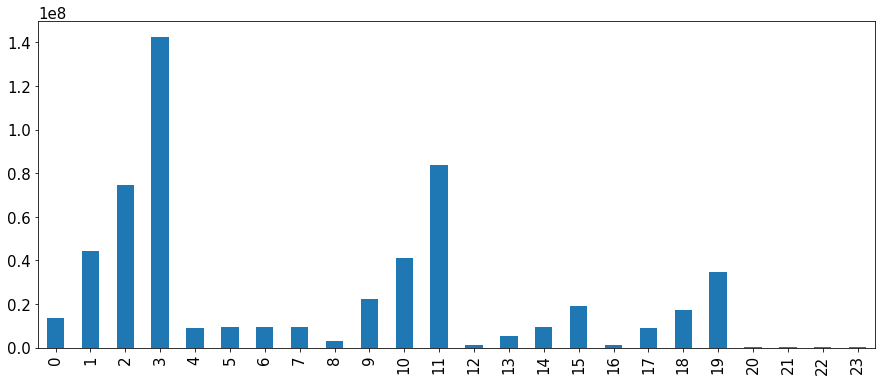

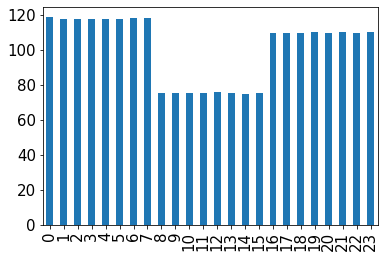

In [327]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

analyze_table['traffic'].plot.bar()

plt.show()

analyze_table['rtt'].plot.bar()

plt.show()
# This shows that the traffic is rising evenly accross multiple timeframes.

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/2754093595.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


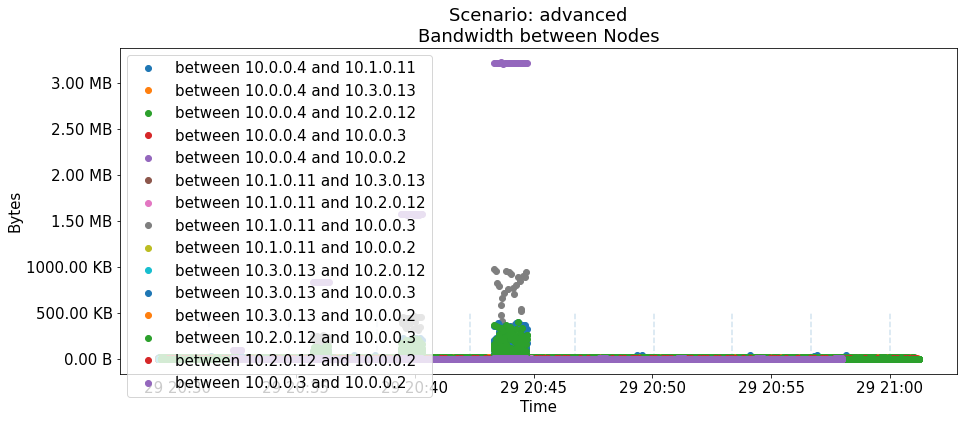

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/2754093595.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


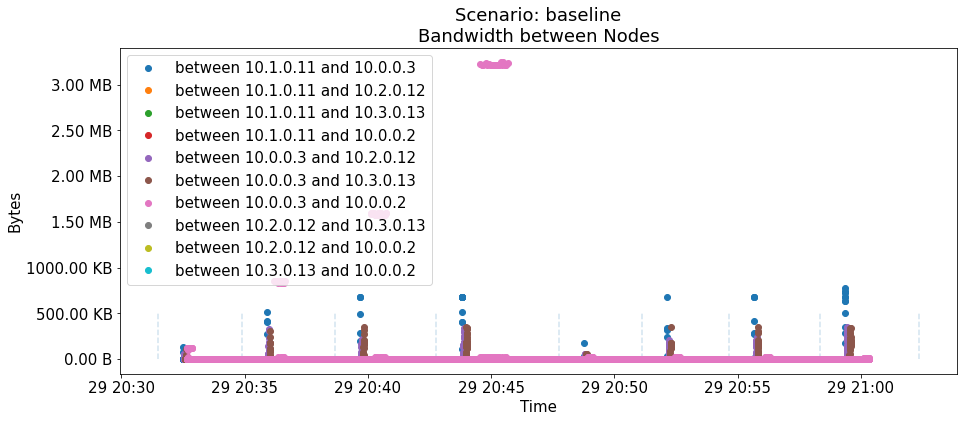

C:\Users\danie\AppData\Local\Temp/ipykernel_33416/2754093595.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in


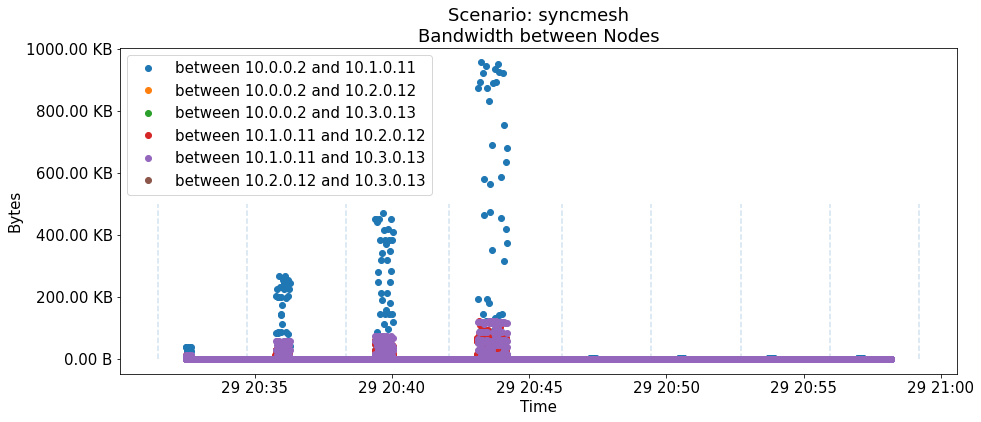

In [328]:
def show_traffic_distribution(dataset, timings, name):
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    # ax.set_ylim(0,500)
    for key in dataset: 
        test = dataset[key].resample('100ms').agg({"ip.len":'sum'})
        ax.plot(test.index, test["ip.len"], label=key, marker='o', linestyle='None')
    # for key in fromClientDataset: 
    #     test = fromClientDataset[key].resample('100ms').agg({"ip.len":'sum'})
    #     ax.plot(test.index, test["ip.len"], label="to " + key, marker='o', linestyle='None')
    # set title and legend

    for timing in list(pd.to_datetime(timings)): 
        ax.vlines(timing, 0, 500000, linestyle='--', alpha=0.2)
    ax.set_title('Scenario: '+name+'\nBandwidth between Nodes')
    ax.set_ylabel("Bytes")
    ax.set_xlabel("Time")
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.4, box.height])
    ax.set_yticklabels([to_human_readable(v) if v >= 0 else ' ' for v in  
                        ax.get_yticks(minor=False)])
    ax.legend(loc='upper left')

    fig.savefig(f"out/bandwidth_between_nodes_{name}.png")
    plt.show()

for key in node_datasets:
    show_traffic_distribution(node_datasets[key], datasets[key][1], key)

# Monitoring

In [329]:
def loadMonitoringDataSet(folder):
    csvfile = os.path.join(Path.cwd(), folder, "monitoring.csv")
    print(csvfile)
    df = pd.read_csv(csvfile)
    df.set_index('timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)

    return df.sort_index()

monitoring_datasets = {}
for source in dataset_sources:
    monitoring_datasets[source] = loadMonitoringDataSet(dataset_sources[source])
    
# test = loadDataSet("data/data-syncmesh-with-latency-3/20210922-17-experiment-syncmesh-with-latency-3")
# monitoring_datasets["advanced"]

c:\Develop\GitHub\DSPJ2021\syncmesh\evaluation\data/data-advanced-mongo-with-latency-3/20210929-21-experiment-advanced-mongo-with-latency-3\monitoring.csv


KeyError: "None of ['timestamp'] are in the columns"

In [ ]:
# Experiments
def splitMonitoringExperiments(df, timings):
    experiments = ["collect1", "collect7", "collect14", "collect30", "aggregate1", "aggregate7", "aggregate14", "aggregate30"]
    return_data = {}
    for index, experiment in enumerate(experiments): 
        return_data[experiment] = df.loc[str(timings[index]):str(timings[index + 1])]
    return return_data

monitoring_experiment_datasets = {}
for key in monitoring_datasets:
    print(key)
    print(datasets[key][1])
    monitoring_experiment_datasets[key] = splitMonitoringExperiments(monitoring_datasets[key], datasets[key][1])

setname = "syncmesh"
for key in monitoring_experiment_datasets[setname]:
    print(key, ":", len(monitoring_experiment_datasets[setname][key]))


advanced
['2021-09-29T21:55:24.392089000' '2021-09-29T21:58:57.075944000'
 '2021-09-29T22:03:03.872087000' '2021-09-29T22:07:40.991976000'
 '2021-09-29T22:13:23.740175000' '2021-09-29T22:16:47.519798000'
 '2021-09-29T22:20:10.831769000' '2021-09-29T22:23:34.612026000'
 '2021-09-29T22:26:59.583984000']
baseline
['2021-09-29T10:12:48.213854000' '2021-09-29T10:16:28.366254000'
 '2021-09-29T10:20:50.757653000' '2021-09-29T10:25:56.360526000'
 '2021-09-29T10:32:46.832236000' '2021-09-29T10:36:23.908510000'
 '2021-09-29T10:40:19.608492000' '2021-09-29T10:44:34.364326000'
 '2021-09-29T10:49:32.908430000']
syncmesh
['2021-09-29T10:12:49.038100000' '2021-09-29T10:16:21.078420000'
 '2021-09-29T10:20:47.958178000' '2021-09-29T10:25:35.054319000'
 '2021-09-29T10:31:25.266420000' '2021-09-29T10:35:02.246300000'
 '2021-09-29T10:38:38.278685000' '2021-09-29T10:42:15.082429000'
 '2021-09-29T10:45:46.098343000']
collect1 : 4
collect7 : 4
collect14 : 5
collect30 : 6
aggregate1 : 4
aggregate7 : 3
aggrega

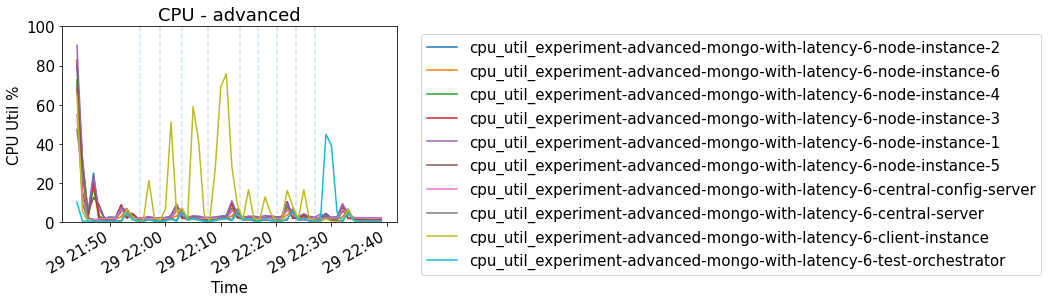

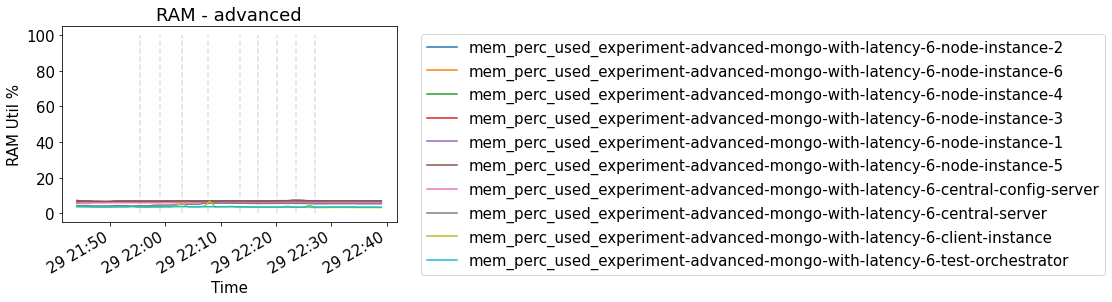

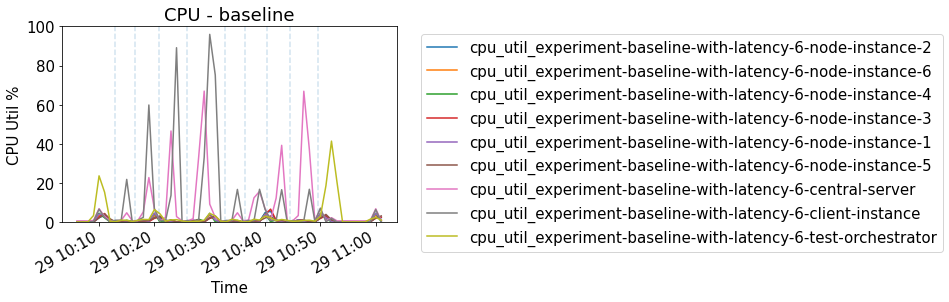

No handles with labels found to put in legend.


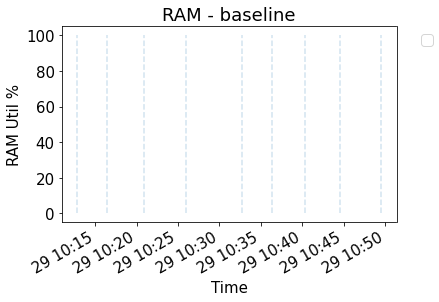

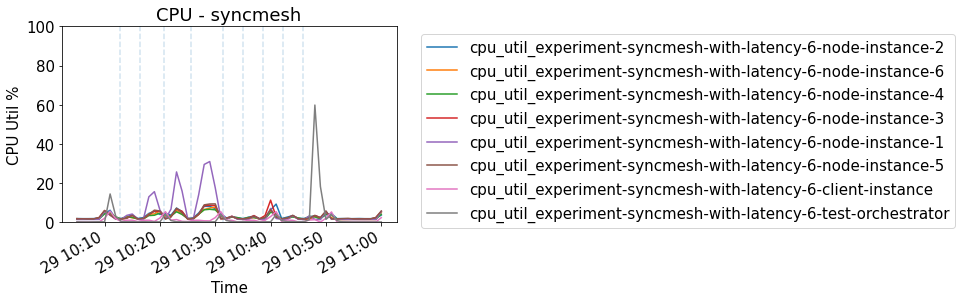

No handles with labels found to put in legend.


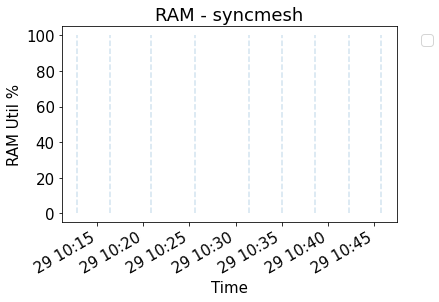

In [ ]:
def drawMonitoringGraphCPU(df, name):
    columns = df.columns
    fig, ax = plt.subplots()
    ax.set_ylim(0,100)

    for col in columns: 
        if col.startswith("cpu_"):
            ax.plot(df.index, df[col]*100, label=col)

    for timing in list(pd.to_datetime(datasets[name][1])): 
        ax.vlines(timing, 0, 100, linestyle='--', alpha=0.2)
    # set title and legend
    ax.set_title('CPU - ' + name)
    ax.set_ylabel("CPU Util %")
    ax.set_xlabel("Time")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()

    fig.savefig("out/cpu_util_" + name + ".png")
    plt.show()

def drawMonitoringGraphRAM(df, name):
    columns = df.columns
    fig, ax = plt.subplots()
    # ax.set_ylim(0,100)
    max_y = 100
    for col in columns: 
        if col.startswith("mem_perc_used") and "used" in col:
            # print(len(df[col]))
            ax.plot(df.index, df[col], label=col)
            max_y = max(max_y, df[col].max())

    for timing in list(pd.to_datetime(datasets[name][1])): 
        ax.vlines(timing, 0, max_y, linestyle='--', alpha=0.2)
    # set title and legend
    ax.set_title('RAM - ' + name)
    ax.set_ylabel("RAM Util %")
    ax.set_xlabel("Time")
    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    box = ax.get_position()
    # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    fig.autofmt_xdate()

    fig.savefig("out/ram_util_" + name + ".png")
    plt.show()


# drawMonitoringGraphRAM(monitoring_datasets["advanced"], source)

# monitoring_datasets["advanced"]["mem_perc_cached_experiment-advanced-mongo-with-latency-3-central-config-server"].min()
# monitoring_datasets["advanced"]["mem_perc_cached_experiment-advanced-mongo-with-latency-3-node-instance-1"].max()
for source in monitoring_datasets:
    drawMonitoringGraphCPU(monitoring_datasets[source], source)
    drawMonitoringGraphRAM(monitoring_datasets[source], source)


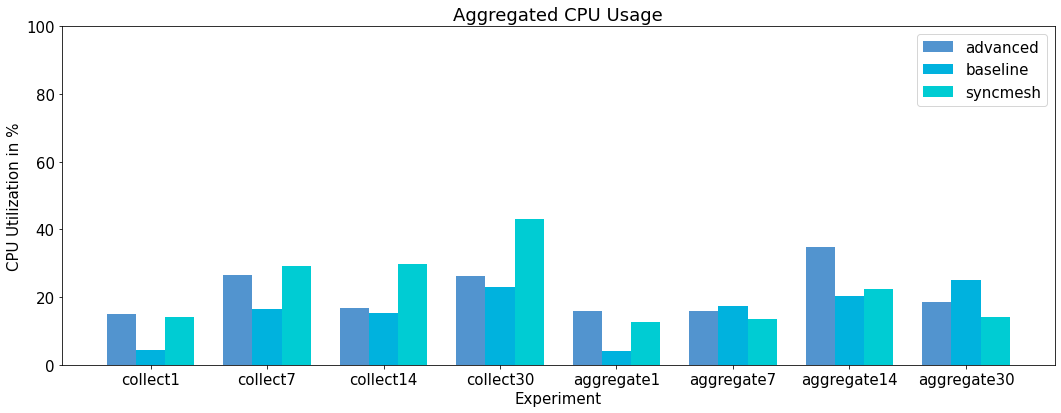

In [ ]:
colors = ["#5294CF", "#00B2DE", "#00CCD3"]
def drawMonitoringCPUComparison(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(15, 6))
    labels = np.array([])
    for index, source in enumerate(experiment_datasets):
        X = np.arange(len(experiment_datasets[source].keys()))
        X_labels = experiment_datasets[source].keys()
        labels = np.append(labels, source)
        sum_cpu_util = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            cpu_util = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("cpu_") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    cpu_util = np.append(cpu_util, [df[col]])
                    # ax.plot(df.index, df[col]*100, label=col)
            # print(cpu_util)
            # print(np.mean(cpu_util))
            # See here for Formula for comparise
            sum_cpu_util = np.append(sum_cpu_util, np.mean(cpu_util) * num_instances)
        # print(sum_cpu_util)
        ax.bar(X - 0.25 + (0.25 * index), sum_cpu_util * 100, color = colors[index], width = 0.25)

    # set title and legend
    ax.set_title('Aggregated CPU Usage')
    ax.set_ylabel("CPU Utilization in %")
    ax.set_ybound(0,100)
    ax.set_xlabel("Experiment")
    ax.legend(labels=labels)
    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig("out/cpu_comparison.png")
    plt.show()

drawMonitoringCPUComparison(monitoring_experiment_datasets)

[0.15141776 0.26399737 0.16787894 0.26297984 0.15839489 0.15924818
 0.34898427 0.18532185]
[0.04228974 0.16391947 0.1522059  0.22934882 0.04136526 0.17392263
 0.20247193 0.24986975]
[0.14159532 0.29324564 0.29753578 0.43124321 0.12684502 0.13512503
 0.2238333  0.14240745]


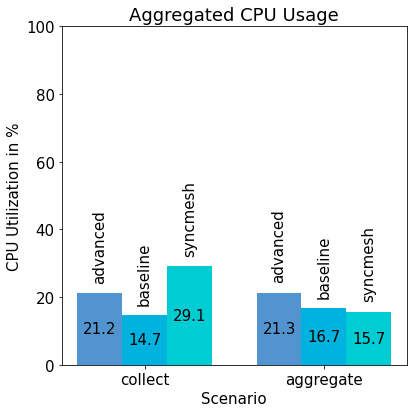

In [ ]:
plt.rcParams.update({'font.size': 15})
# Only use two buckets collect and aggregate
def drawMonitoringCPUComparisonAggregate(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
    labels = np.array([])
    X_labels = np.array(["collect", "aggregate"])
    X = np.arange(2)

    for index, source in enumerate(experiment_datasets):
        labels = np.append(labels, source)
        sum_cpu_util = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            cpu_util = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("cpu_") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    cpu_util = np.append(cpu_util, [df[col]])
                    # ax.plot(df.index, df[col]*100, label=col)
            # print(cpu_util)
            # print(np.mean(cpu_util))
            # See here for Formula for comparise
            sum_cpu_util = np.append(sum_cpu_util, np.mean(cpu_util) * num_instances)

        print(sum_cpu_util)
        y = np.array([sum_cpu_util[0:4].mean(), sum_cpu_util[4:8].mean()])
        bar = ax.bar(X - 0.25 + (0.25 * index), y*100, color = colors[index], width = 0.25)
        ax.bar_label(bar, label_type='center',fmt='%.1f')
        # for y_i in range(len(y)):
        for x_i in range(len(X)):
            plt.text(x_i - 0.25 + (0.25 * index), y[x_i] * 100 +4, labels[index], ha = 'center',  rotation=90)
    # set title and legend
    ax.set_title('Aggregated CPU Usage')
    ax.set_ylabel("CPU Utilization in %")
    ax.set_ybound(0,100)
    ax.set_xlabel("Scenario")
    # ax.legend(labels=labels)

    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig("out/cpu_comparison_aggregated.png")
    
    plt.show()

drawMonitoringCPUComparisonAggregate(monitoring_experiment_datasets)

[5.81504614e+09 9.86751795e+09 7.95504230e+09 1.21469665e+10
 6.06634394e+09 8.16375398e+09 6.23573811e+09 6.24404890e+09]
[0.06445747 0.06661601]
[0. 0. 0. 0. 0. 0. 0. 0.]


C:\Users\danie\AppData\Local\Temp/ipykernel_33416/3622157776.py:37: RuntimeWarning: invalid value encountered in double_scalars
  y = np.array([sum_mem_used[0:4].sum() / (sum_mem_used[0:4].sum() + sum_mem_free[0:4].sum()), sum_mem_used[4:8].sum() / (sum_mem_used[4:8].sum() + sum_mem_free[4:8].sum())])


[nan nan]
[0. 0. 0. 0. 0. 0. 0. 0.]
[nan nan]


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


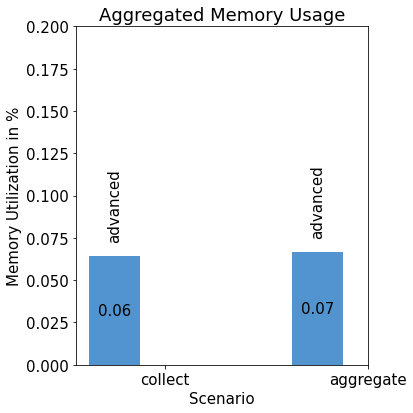

In [ ]:
plt.rcParams.update({'font.size': 15})
# Only use two buckets collect and aggregate
def drawMonitoringRAMComparisonAggregate(experiment_datasets):
    fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(6, 6))
    labels = np.array([])
    X_labels = np.array(["collect", "aggregate"])
    X = np.arange(2)

    for index, source in enumerate(experiment_datasets):
        labels = np.append(labels, source)
        sum_mem_used = np.array([])
        sum_mem_free = np.array([])
        for experiment in experiment_datasets[source]:
            df = experiment_datasets[source][experiment]
            columns = df.columns

            mem_used = np.array([])
            mem_perc_used = np.array([])
            mem_free = np.array([])
            num_instances = 0 
            for col in columns: 
                if col.startswith("mem_used") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    num_instances = num_instances + 1
                    mem_used = np.append(mem_used, [df[col]])
                if col.startswith("mem_perc_used") and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    mem_perc_used = np.append(mem_perc_used, [df[col]])
                if (col.startswith("mem_free") or col.startswith("mem_slab") or col.startswith("mem_cached") or col.startswith("mem_buffered")) and "orchestrator" not in col and "client" not in col:
                    # print(df[col])
                    mem_free = np.append(mem_free, [df[col]])
            # See here for Formula for comparise
            sum_mem_used = np.append(sum_mem_used, np.sum(mem_used))
            sum_mem_free = np.append(sum_mem_free, np.sum(mem_free))

        print(sum_mem_used)
        y = np.array([sum_mem_used[0:4].sum() / (sum_mem_used[0:4].sum() + sum_mem_free[0:4].sum()), sum_mem_used[4:8].sum() / (sum_mem_used[4:8].sum() + sum_mem_free[4:8].sum())])
        print(y)
        bar = ax.bar(X - 0.25 + (0.25 * index), y, color = colors[index], width = 0.25)
        ax.bar_label(bar, label_type='center',fmt='%.2f')
        # for y_i in range(len(y)):
        for x_i in range(len(X)):
            plt.text(x_i - 0.25 + (0.25 * index), y[x_i]+ 0.01, labels[index], ha = 'center',  rotation=90)
    # set title and legend
    ax.set_title('Aggregated Memory Usage')
    ax.set_ylabel("Memory Utilization in %")
    ax.set_ybound(0,0.2)
    ax.set_xlabel("Scenario")
    # ax.legend(labels=labels)

    # box = ax.get_position()
    # # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    # ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    # fig.autofmt_xdate()
    plt.xticks(X, X_labels)
    fig.savefig("out/ram_comparison_aggregated.png")
    
    plt.show()

drawMonitoringRAMComparisonAggregate(monitoring_experiment_datasets)